##### Styling

In [114]:
from IPython.core.display import HTML
HTML("""
<style>
.usecase-title, .usecase-duration, .usecase-section-header {
    padding-left: 15px;
    padding-bottom: 10px;
    padding-top: 10px;
    padding-right: 15px;
    background-color: #0f9295;
    color: #fff;
}

.usecase-title {
    font-size: 1.7em;
    font-weight: bold;
}

.usecase-authors, .usecase-level, .usecase-skill {
    padding-left: 15px;
    padding-bottom: 7px;
    padding-top: 7px;
    background-color: #baeaeb;
    font-size: 1.4em;
    color: #121212;
}

.usecase-level-skill  {
    display: flex;
}

.usecase-level, .usecase-skill {
    width: 50%;
}

.usecase-duration, .usecase-skill {
    text-align: right;
    padding-right: 15px;
    padding-bottom: 8px;
    font-size: 1.4em;
}

.usecase-section-header {
    font-weight: bold;
    font-size: 1.5em;
}

.usecase-subsection-header, .usecase-subsection-blurb {
    font-weight: bold;
    font-size: 1.2em;
    color: #121212;
}

.usecase-subsection-blurb {
    font-size: 1em;
    font-style: italic;
}
</style>
""")

# Renewable Energy Optimization

<div class="usecase-title">Renewable Energy Optimization</div>

<div class="usecase-authors"><b>Authored by: </b> Sinan Kilci</div>

<div class="usecase-duration"><b>Duration:</b> 600 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate </div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python </div>
</div>

The main goal of this project is to use historical environmental data to improve the installation and operation of renewable energy sources like wind turbines and solar panels. The aim is to make energy production more efficient and sustainable by studying environmental factors that affect energy production. The results will help us understand the best places to put renewable energy sources and how to operate them more effectively, using detailed environmental information to boost efficiency and sustainability.

At the end of this use case we will:
- have a clear understanding of how environmental data can be leveraged to optimize the placement and operation of renewable energy sources like wind turbines and solar panels
- access to visualizations that effectively communicate the trends and patterns found in the data, providing an intuitive grasp of complex environmental factors
- explore detailed data analysis and wrangling techniques that refine raw data into actionable insights, highlighting key variables affecting renewable energy efficiency and sustainability
- be exposed to predictive models that forecast energy production potential based on historical environment data, offering strategic insights for future planning and investment.

# Introduction

<div class="usecase-section-header">Optimizing Renewable Energy Deployment Using Environmental Sensor Data</div>

In recent years, the global need for renewable energy has been increased as we strive to reduce carbon emissions and reduce the effects of climate change. Renewable energy sources, such as wind turbines and solar panels, play a critical role in this transition. However, the efficiency and effectiveness of these installations are heavily influenced by environmental conditions. Placing a wind turbine in an area with inconsistent wind patterns or a solar panel where sunlight is obstructed can lead to weak performance and increased costs.

This study aims to address these challenges by leveraging detailed environmental data from microclimate and meshed sensor networks. By analyzing factors such as wind speed, solar radiation, temperature, and humidity, we can identify optimal locations and operational strategies for renewable energy installations. The goal is to maximize energy generation, improve cost-efficiency, and reduce environmental impact.

The datasets used in this study are gathered from City of Melbourne Open Data Platform (https://data.melbourne.vic.gov.au) and provide extensive insights into local environmental conditions in Melbourne City. They include:
- Weather Stations Data (ATMOS 41): Historical data collected by weather stations installed in Argyle Square, capturing wind speed, solar radiation, and atmospheric conditions. This information is crucial for assessing site suitability for renewable energy projects.
- Microclimate Sensors Data: Contains climate readings from sensors located within the city, updated every fifteen minutes. This dataset includes ambient air temperature, relative humidity, atmospheric pressure, wind speed and direction, gust wind speed, particulate matter 2.5, particulate matter 10, and noise. It is essential for understanding microclimate variations throughout the day.
- Microclimate Sensor Locations: Provides the historical location and description for each microclimate sensor device installed throughout the city. This data is vital for understanding the spatial distribution of sensors and any relocations that may affect historical data interpretation.
- Microclimate Sensor Readings: Offers environmental readings updated every hour in fifteen-minute increments. It includes data on ambient air temperature, relative humidity, barometric pressure, particulate matter 2.5, particulate matter 10, and average wind speed. This dataset also aligns with EPA Victoria's air quality data, helping correlate microclimate conditions with broader environmental insights.

##### Importing the required libraries

In [115]:
import requests
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

##### Requesting the datasets from their sources (Download)

In [116]:
urls = {
    "microclimate_sensor_readings": "https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/microclimate-sensor-readings/exports/csv?lang=en&timezone=Australia%2FSydney&use_labels=true&delimiter=%2C",
    "microclimate_sensors_data": "https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/microclimate-sensors-data/exports/csv?lang=en&timezone=Australia%2FMelbourne&use_labels=true&delimiter=%2C",
    "meshed_sensor_type_1": "https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/meshed-sensor-type-1/exports/csv?lang=en&timezone=Australia%2FSydney&use_labels=true&delimiter=%2C"
}

# Function to download a dataset
def download_dataset(url, filename):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {filename} successfully.")
    else:
        print(f"Failed to download {filename}. Status code: {response.status_code}")

# Download each dataset
for name, url in urls.items():
    download_dataset(url, f"{name}.csv")


Downloaded microclimate_sensor_readings.csv successfully.
Downloaded microclimate_sensors_data.csv successfully.
Downloaded meshed_sensor_type_1.csv successfully.


##### Loading datasets

In [117]:
microclimate_sensor_readings = pd.read_csv('microclimate_sensor_readings.csv')
microclimate_sensors_data = pd.read_csv('microclimate_sensors_data.csv')
meshed_sensor_type_1 = pd.read_csv('meshed_sensor_type_1.csv')

##### Converting time related columns to datetime

In [118]:
microclimate_sensor_readings['Local_Time'] = pd.to_datetime(microclimate_sensor_readings['Local_Time'], errors='coerce', utc=True)
microclimate_sensors_data['Time'] = pd.to_datetime(microclimate_sensors_data['Time'], errors='coerce', utc=True)
meshed_sensor_type_1['date_measure'] = pd.to_datetime(meshed_sensor_type_1['date_measure'], errors='coerce', utc=True)

##### Check for missing values

In [119]:
print("Total rows in wrangled_microclimate_sensor_readings:", len(microclimate_sensor_readings))
print("Total rows in wrangled_microclimate_sensors_data:", len(microclimate_sensors_data))
print("Total rows in wrangled_meshed_sensor_type_1:", len(meshed_sensor_type_1))

print("Missing Values in Microclimate Sensor Readings:\n", microclimate_sensor_readings.isnull().sum())
print("Missing Values in Microclimate Sensors Data:\n", microclimate_sensors_data.isnull().sum())
print("Missing Values in Meshed Sensor Type 1:\n", meshed_sensor_type_1.isnull().sum())

Total rows in wrangled_microclimate_sensor_readings: 56
Total rows in wrangled_microclimate_sensors_data: 51823
Total rows in wrangled_meshed_sensor_type_1: 119893
Missing Values in Microclimate Sensor Readings:
 Local_Time       0
ID               0
Site_ID          0
Sensor_ID        0
Value            0
Type             0
Units            0
Gatewayhub_ID    0
Site_Status      0
dtype: int64
Missing Values in Microclimate Sensors Data:
 Device_id                  0
Time                       0
SensorLocation           803
LatLong                  803
MinimumWindDirection    6767
AverageWindDirection      20
MaximumWindDirection    6767
MinimumWindSpeed        6767
AverageWindSpeed          20
GustWindSpeed           6767
AirTemperature            20
RelativeHumidity          20
AtmosphericPressure       20
PM25                    4698
PM10                    4698
Noise                   4698
dtype: int64
Missing Values in Meshed Sensor Type 1:
 dev_id                    0
date_measur

##### Sorting the data by time

In [120]:
microclimate_sensors_data.sort_values('Time', inplace=True)

##### Extract time-based features

In [121]:
microclimate_sensors_data['hour'] = microclimate_sensors_data['Time'].dt.hour
microclimate_sensors_data['day'] = microclimate_sensors_data['Time'].dt.day
microclimate_sensors_data['month'] = microclimate_sensors_data['Time'].dt.month

##### Handling the missing values

In [122]:
# Identify existing Device_id to SensorLocation and LatLong mappings
location_mapping = microclimate_sensors_data.dropna(subset=['SensorLocation']).set_index('Device_id')['SensorLocation'].to_dict()
latlong_mapping = microclimate_sensors_data.dropna(subset=['LatLong']).set_index('Device_id')['LatLong'].to_dict()

# Fill missing SensorLocation values based on Device_id
microclimate_sensors_data['SensorLocation'] = microclimate_sensors_data.apply(
    lambda row: location_mapping.get(row['Device_id'], row['SensorLocation']), axis=1
)

# Fill missing LatLong values based on Device_id
microclimate_sensors_data['LatLong'] = microclimate_sensors_data.apply(
    lambda row: latlong_mapping.get(row['Device_id'], row['LatLong']), axis=1
)

# Check if the missing values in SensorLocation and LatLong are filled
print("Missing Values in SensorLocation after filling:\n", microclimate_sensors_data['SensorLocation'].isnull().sum())
print("Missing Values in LatLong after filling:\n", microclimate_sensors_data['LatLong'].isnull().sum())

# Drop rows where all specified wind-related columns are 0
columns_to_check = [
    'MinimumWindDirection', 'AverageWindDirection', 'MaximumWindDirection',
    'MinimumWindSpeed', 'AverageWindSpeed', 'GustWindSpeed'
]

microclimate_sensors_data = microclimate_sensors_data[
    ~(microclimate_sensors_data[columns_to_check] == 0).all(axis=1)
].copy()

microclimate_sensors_data.dropna(subset=['AirTemperature', 'RelativeHumidity', 'AtmosphericPressure'], inplace=True)
meshed_sensor_type_1.dropna(inplace=True)

Missing Values in SensorLocation after filling:
 0
Missing Values in LatLong after filling:
 0


##### Drop the unnecessary columns

In [123]:
microclimate_sensors_data.drop(columns=['PM10', 'PM25', 'Noise', 'MinimumWindDirection', 'MaximumWindDirection'], inplace=True)

##### Handling and checking the data in empty fields in Microclimate dataset

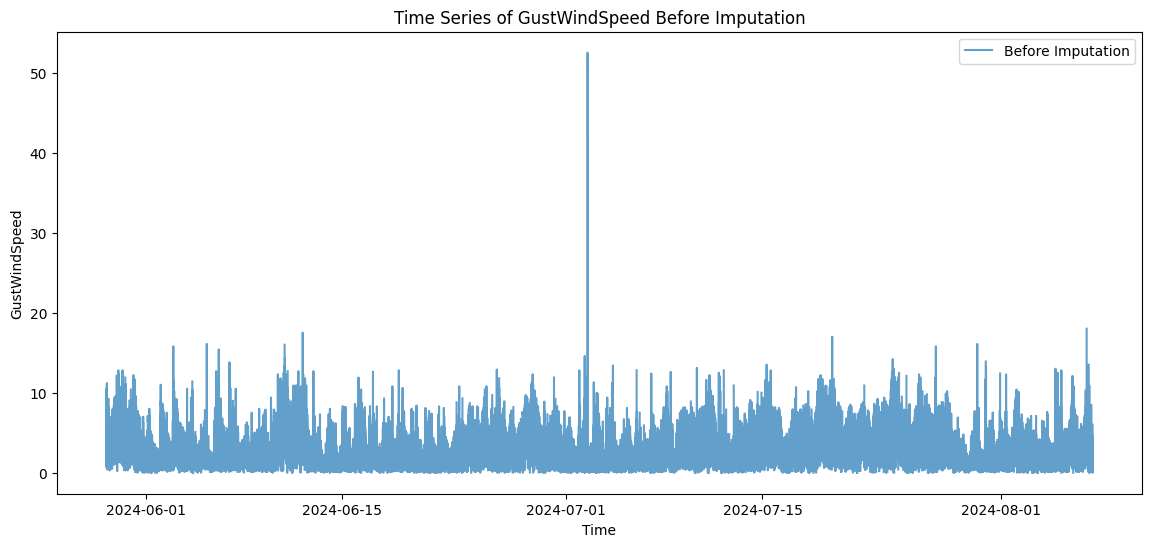

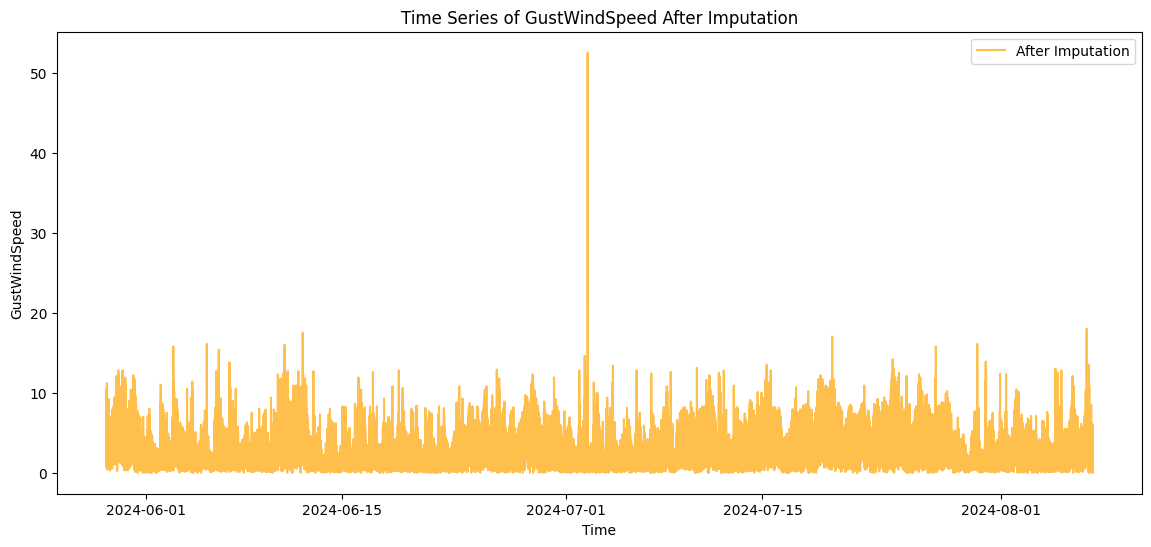

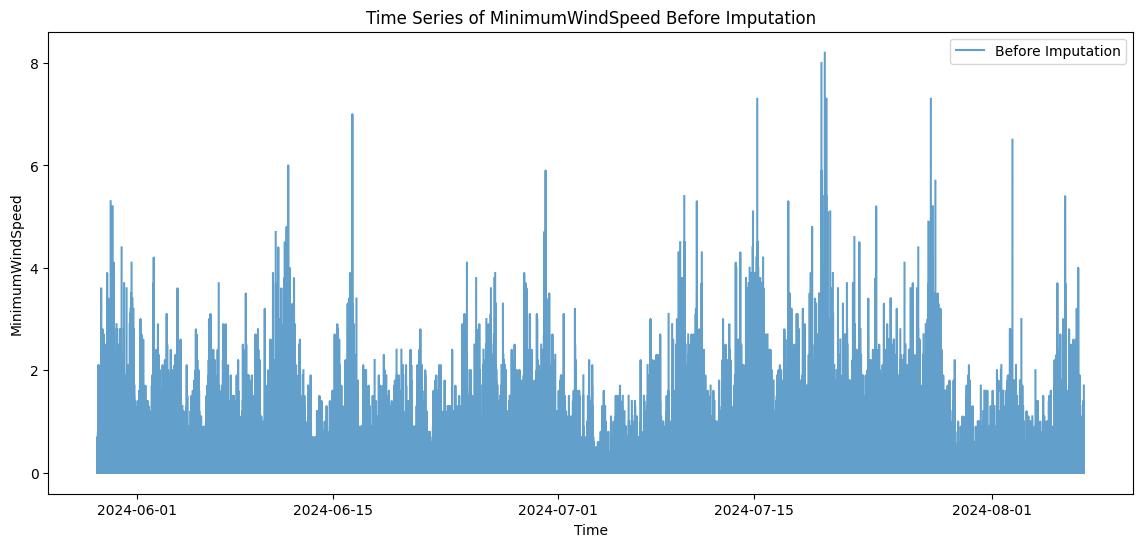

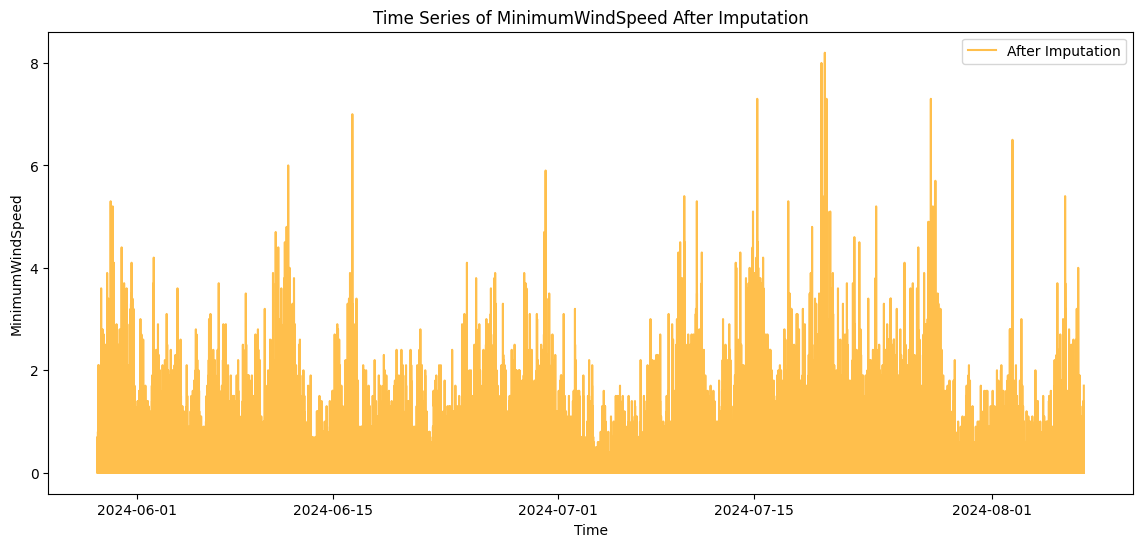

In [124]:
def impute_and_plot_knn(target_column, feature_columns, data):
    plt.figure(figsize=(14, 6))
    plt.plot(data['Time'], data[target_column], label='Before Imputation', alpha=0.7)
    plt.title(f'Time Series of {target_column} Before Imputation')
    plt.xlabel('Time')
    plt.ylabel(target_column)
    plt.legend()
    plt.show()

    complete_data = data.dropna(subset=[target_column])
    missing_data = data[data[target_column].isnull()]

    X = complete_data[feature_columns]
    y = complete_data[target_column]

    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

    # KNN regression model
    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_model.fit(X_train, y_train)

    missing_X = missing_data[feature_columns]
    missing_X_imputed = imputer.transform(missing_X)

    predicted_values = knn_model.predict(missing_X_imputed)

    # Ensure non-negative predictions for wind speed
    predicted_values = np.maximum(predicted_values, 0)

    data.loc[missing_data.index, target_column] = predicted_values

    plt.figure(figsize=(14, 6))
    plt.plot(data['Time'], data[target_column], label='After Imputation', alpha=0.7, color='orange')
    plt.title(f'Time Series of {target_column} After Imputation')
    plt.xlabel('Time')
    plt.ylabel(target_column)
    plt.legend()
    plt.show()

# Define target variables and their respective features
targets = ['GustWindSpeed', 'MinimumWindSpeed']
features = ['hour', 'day', 'month', 'AverageWindSpeed', 'AirTemperature', 'RelativeHumidity', 'AtmosphericPressure']

for target in targets:
    impute_and_plot_knn(target, features, microclimate_sensors_data)

##### I identified some of the average wind speed values are less then minimum wind speed. I'm using predictive data wrangling method (KNN) to fix that.

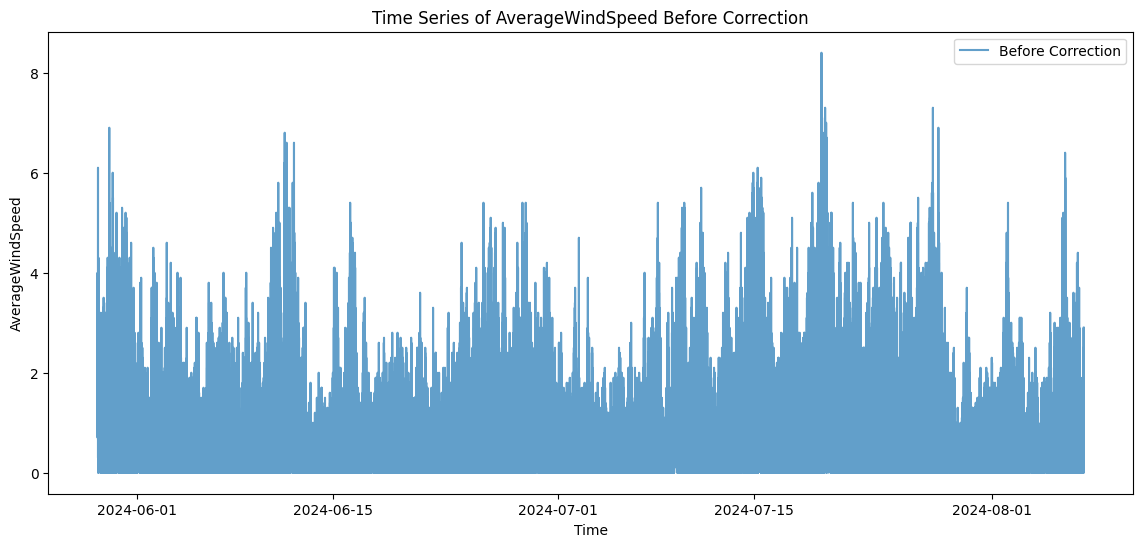

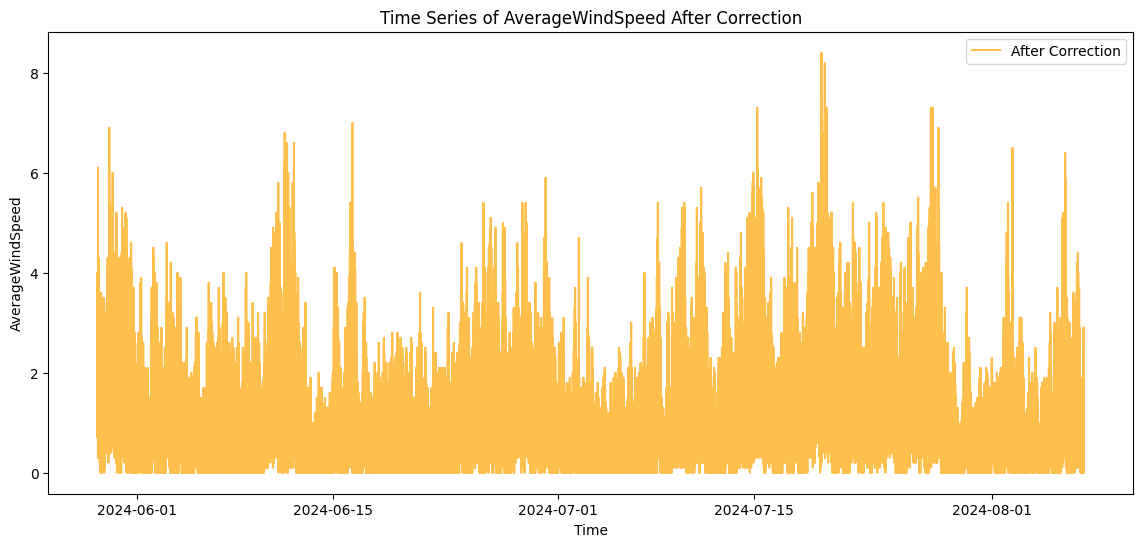

In [125]:
# Plot before correction
plt.figure(figsize=(14, 6))
plt.plot(microclimate_sensors_data['Time'], microclimate_sensors_data['AverageWindSpeed'], label='Before Correction', alpha=0.7)
plt.title('Time Series of AverageWindSpeed Before Correction')
plt.xlabel('Time')
plt.ylabel('AverageWindSpeed')
plt.legend()
plt.show()

# Identify rows where AverageWindSpeed is less than MinimumWindSpeed
incorrect_avg_wind = microclimate_sensors_data[microclimate_sensors_data['AverageWindSpeed'] < microclimate_sensors_data['MinimumWindSpeed']]

complete_data = microclimate_sensors_data.drop(incorrect_avg_wind.index)

# Define features and target
features = ['hour', 'day', 'month', 'MinimumWindSpeed', 'GustWindSpeed', 'AirTemperature', 'RelativeHumidity', 'AtmosphericPressure']
X = complete_data[features]
y = complete_data['AverageWindSpeed']

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Train the KNN regression model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_imputed, y)

missing_X = incorrect_avg_wind[features]
missing_X_imputed = imputer.transform(missing_X)
predicted_values = knn_model.predict(missing_X_imputed)

# Ensure predictions are within bounds
predicted_values = np.clip(predicted_values, incorrect_avg_wind['MinimumWindSpeed'], incorrect_avg_wind['GustWindSpeed'])

microclimate_sensors_data.loc[incorrect_avg_wind.index, 'AverageWindSpeed'] = predicted_values

# Plot after correction
plt.figure(figsize=(14, 6))
plt.plot(microclimate_sensors_data['Time'], microclimate_sensors_data['AverageWindSpeed'], label='After Correction', alpha=0.7, color='orange')
plt.title('Time Series of AverageWindSpeed After Correction')
plt.xlabel('Time')
plt.ylabel('AverageWindSpeed')
plt.legend()
plt.show()

##### Check one more time for the missing values

In [126]:
print("Missing Values in Microclimate Sensor Readings:\n", microclimate_sensor_readings.isnull().sum())
print("Missing Values in Microclimate Sensors Data:\n", microclimate_sensors_data.isnull().sum())
print("Missing Values in Meshed Sensor Type 1:\n", meshed_sensor_type_1.isnull().sum())

Missing Values in Microclimate Sensor Readings:
 Local_Time       0
ID               0
Site_ID          0
Sensor_ID        0
Value            0
Type             0
Units            0
Gatewayhub_ID    0
Site_Status      0
dtype: int64
Missing Values in Microclimate Sensors Data:
 Device_id               0
Time                    0
SensorLocation          0
LatLong                 0
AverageWindDirection    0
MinimumWindSpeed        0
AverageWindSpeed        0
GustWindSpeed           0
AirTemperature          0
RelativeHumidity        0
AtmosphericPressure     0
hour                    0
day                     0
month                   0
dtype: int64
Missing Values in Meshed Sensor Type 1:
 dev_id                 0
date_measure           0
RTC                    0
battery                0
solarPanel             0
command                0
solar                  0
precipitation          0
strikes                0
windSpeed              0
windDirection          0
gustSpeed              0
vap

##### Removing outilers

In [127]:
def remove_outliers_zscore(df, columns, z_threshold=3.0):
    for column in columns:
        mean_col = df[column].mean()
        std_col = df[column].std()

        z_scores = (df[column] - mean_col) / std_col

        df = df[(z_scores > -z_threshold) & (z_scores < z_threshold)]
    return df

# Columns to check for outliers in microclimate data
columns_to_check_microclimate_sensors_data = [
    'AirTemperature', 'RelativeHumidity', 'AtmosphericPressure',
    'MinimumWindSpeed', 'AverageWindSpeed', 'GustWindSpeed',
    'AverageWindDirection'
]

# Columns to check for outliers in meshed sensor data
columns_to_check_meshed_sensor_type_1 = [
    'solar', 'windSpeed', 'gustSpeed',
    'vapourPressure', 'atmosphericPressure', 'relativeHumidity',
    'airTemp'
]

# Remove outliers from the specified columns
wrangled_microclimate_sensors_data = remove_outliers(microclimate_sensors_data, columns_to_check_microclimate_sensors_data)
wrangled_meshed_sensor_type_1 = remove_outliers(meshed_sensor_type_1, columns_to_check_meshed_sensor_type_1)

print("Number of rows after removing outliers from Microclimate data:", len(wrangled_microclimate_sensors_data))
print("Number of rows after removing outliers from Meshed Sensor data:", len(wrangled_meshed_sensor_type_1))

Number of rows after removing outliers from Microclimate data: 46491
Number of rows after removing outliers from Meshed Sensor data: 110589


#### NEXT: Data Merging